# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/644.9 MB 52.0 kB/s eta 3:26:38
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 473, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readint

In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.9 MB/s eta 0:00:00


In [ ]:
# QAT version

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow_model_optimization.python.core.keras.compat import keras


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

ModuleNotFoundError: No module named 'tensorflow_model_optimization'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/ECE532/project/data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='/content/gdrive/MyDrive/ECE532/project/data', cache_subdir='mini_speech_commands')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/ECE532/project/data/mini_speech_commands/mini_speech_commands_extracted/mini_speech_commands')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
for audio, labels in train_ds.take(1):
    print("Audio shape:", audio.shape)

Audio shape: (64, 16000, 1)


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

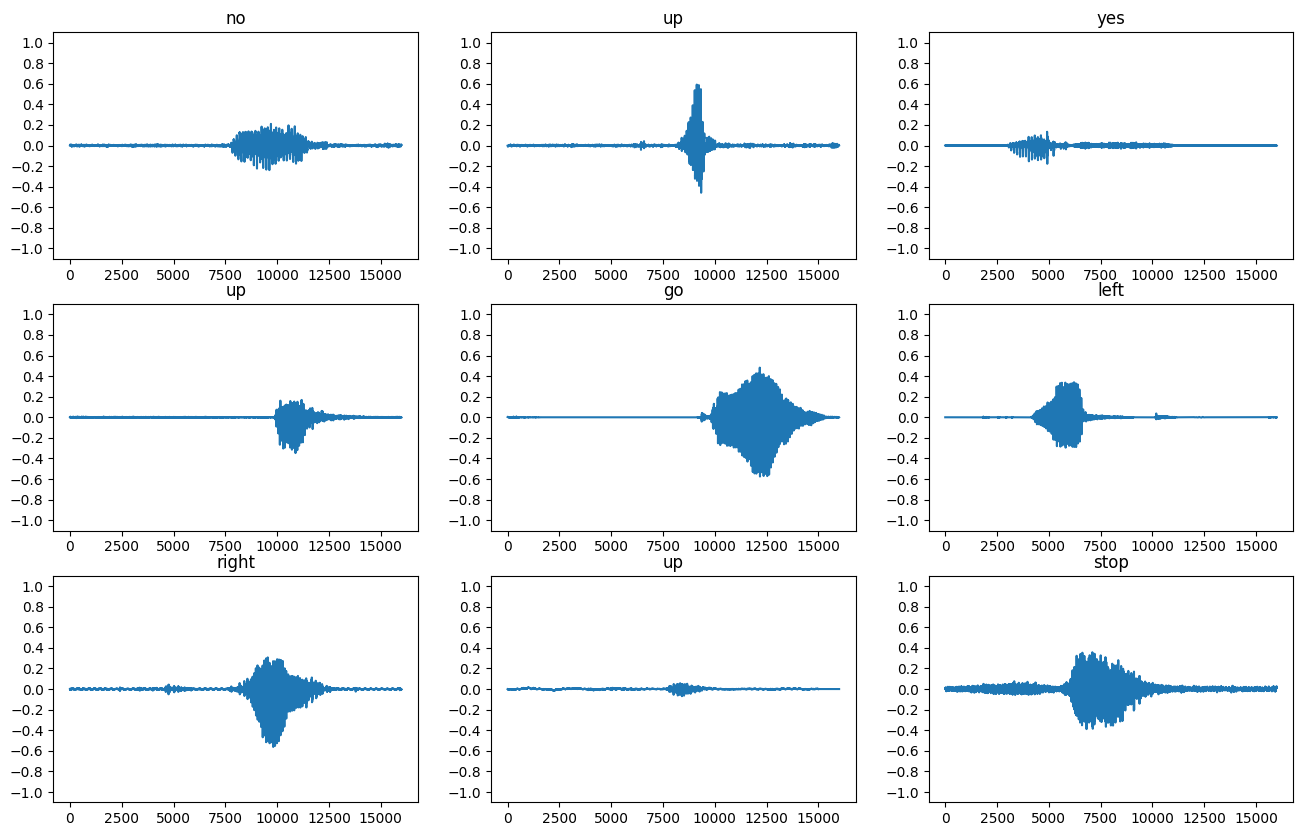

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

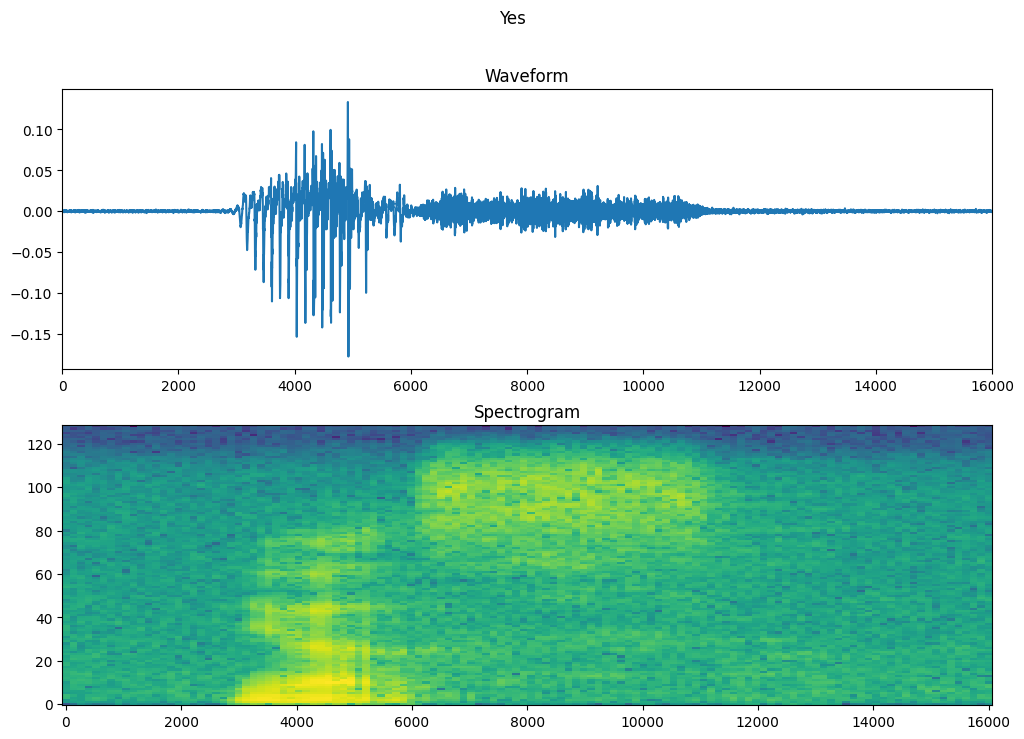

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

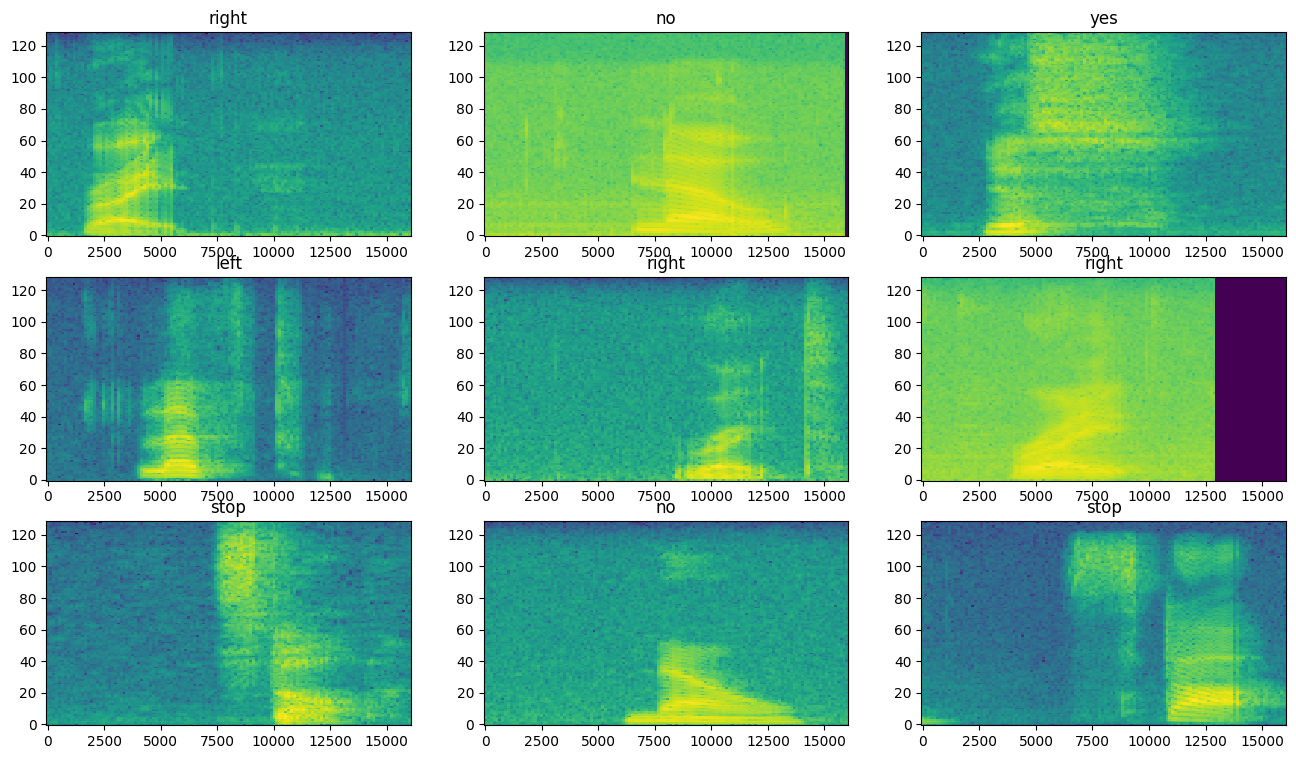

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
# RESIZING AND NORMALIZATION LAYER TAKEN OUT, QAT
# Final Model Definition


# Assume example_spectrograms is obtained from your dataset so that
# input_shape represents the original spectrogram dimensions.
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)

# Define the model without resizing and normalization layers.
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    # Removed: keras.layers.Resizing(32, 32),
    # Removed: normalization layer (e.g., keras.layers.Normalization())

    # The rest of your model architecture:
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 125, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 62, 64)        0         
                                                                 
 flatten (Flatten)           (None, 238080)            0         
                                                                 
 dense (Dense)               (None, 128)               30474368  
                             

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
# QAT version for compile

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model:

In [ ]:
#QAT
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
100/100 [==============================] - 1833s 6s/step - loss: 1.7271 - accuracy: 0.3913 - val_loss: 1.1795 - val_accuracy: 0.6680
Epoch 2/20
100/100 [==============================] - 8s 78ms/step - loss: 1.1030 - accuracy: 0.6266 - val_loss: 0.9410 - val_accuracy: 0.7279
Epoch 3/20
100/100 [==============================] - 8s 78ms/step - loss: 0.7990 - accuracy: 0.7341 - val_loss: 0.6853 - val_accuracy: 0.8021
Epoch 4/20
100/100 [==============================] - 8s 78ms/step - loss: 0.5893 - accuracy: 0.7961 - val_loss: 0.6543 - val_accuracy: 0.8177
Epoch 5/20
100/100 [==============================] - 8s 78ms/step - loss: 0.4525 - accuracy: 0.8469 - val_loss: 0.6195 - val_accuracy: 0.8216
Epoch 6/20
100/100 [==============================] - 8s 78ms/step - loss: 0.3653 - accuracy: 0.8795 - val_loss: 0.6562 - val_accuracy: 0.8359
Epoch 7/20
100/100 [==============================] - 8s 79ms/step - loss: 0.2933 - accuracy: 0.9047 - val_loss: 0.6315 - val_accuracy: 0.830

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

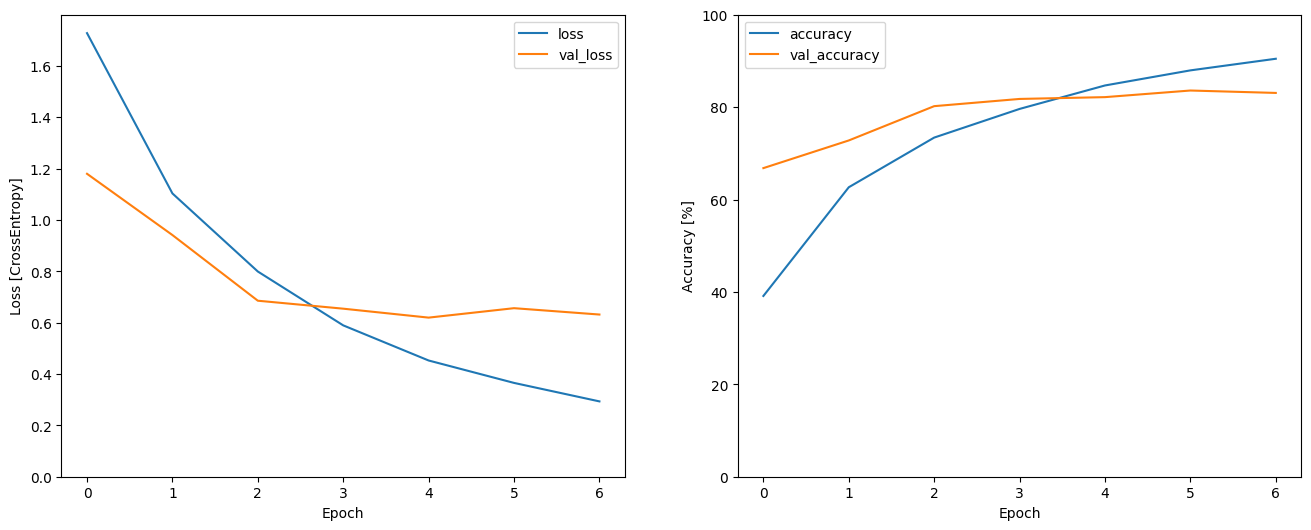

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 26s 2s/step - loss: 0.6708 - accuracy: 0.8125


{'loss': 0.670785665512085, 'accuracy': 0.8125}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 18ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

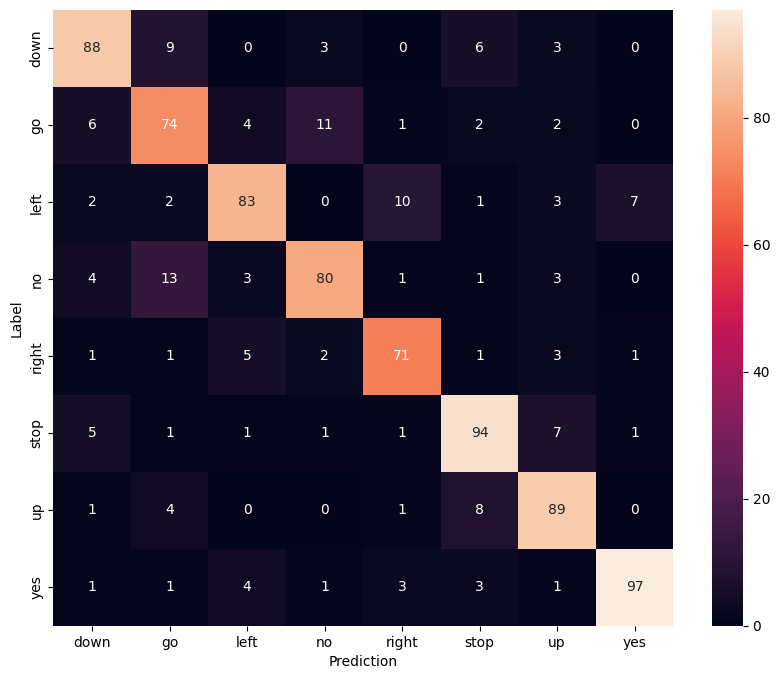

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.

# Quantization Aware Training




In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 125, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 62, 64)        0         
                                                                 
 flatten (Flatten)           (None, 238080)            0         
                                                                 
 dense (Dense)               (None, 128)               30474368  
                                                        

In [ ]:
print(type(model))


<class 'tf_keras.src.engine.sequential.Sequential'>


In [ ]:
print("Is GraphNetwork:", getattr(model, "_is_graph_network", None))

Is GraphNetwork: True


Train QAT model:

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Assume 'model' is your previously defined and compiled Keras model.
# Create a QAT version of the model:
q_aware_model = tfmot.quantization.keras.quantize_model(model)

# Compile the QAT model.
# It is often beneficial to use a lower learning rate during fine-tuning.
q_aware_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.5e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune the QAT model with your training data.
# You may want to increase the number of epochs for better adaptation.
q_aware_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=15  # Adjust this as needed.
)

print("Evaluation:")
# Optionally evaluate the QAT model on your test dataset:
q_aware_model.evaluate(test_spectrogram_ds)

# Convert the QAT model to a fully quantized TFLite model:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# You can still use a representative dataset for calibration if desired.
converter.representative_dataset = representative_data_gen

# Force the converter to use integer-only operations:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8, depending on your choice
converter.inference_output_type = tf.uint8

tflite_model_quant_qat = converter.convert()

# Save the QAT-based quantized model:
import pathlib
tflite_models_dir = pathlib.Path("/content/gdrive/MyDrive/ECE532/project/models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_quant_qat_file = tflite_models_dir / "cnn_model_quant_qat.tflite"
tflite_model_quant_qat_file.write_bytes(tflite_model_quant_qat)


Epoch 1/15
100/100 [==============================] - 13s 106ms/step - loss: 0.5358 - accuracy: 0.7800 - val_loss: 0.7206 - val_accuracy: 0.7552
Epoch 2/15
100/100 [==============================] - 10s 103ms/step - loss: 0.4290 - accuracy: 0.8480 - val_loss: 0.6821 - val_accuracy: 0.7786
Epoch 3/15
100/100 [==============================] - 10s 103ms/step - loss: 0.4364 - accuracy: 0.8575 - val_loss: 0.6776 - val_accuracy: 0.7904
Epoch 4/15
100/100 [==============================] - 10s 104ms/step - loss: 0.3863 - accuracy: 0.8755 - val_loss: 0.6749 - val_accuracy: 0.7995
Epoch 5/15
100/100 [==============================] - 10s 103ms/step - loss: 0.3606 - accuracy: 0.8788 - val_loss: 0.6739 - val_accuracy: 0.8021
Epoch 6/15
100/100 [==============================] - 10s 104ms/step - loss: 0.3161 - accuracy: 0.8911 - val_loss: 0.6816 - val_accuracy: 0.8099
Epoch 7/15
100/100 [==============================] - 11s 105ms/step - loss: 0.2716 - accuracy: 0.9100 - val_loss: 0.6967 - val_ac

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


30501464

Evaluate quantized model:

In [ ]:

def evaluate_tflite_model(tflite_model_file, dataset):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()

    # Get input and output tensor details.
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = []
    true_labels = []

    for spectrogram, labels in dataset:
        spectrogram_np = spectrogram.numpy()
        labels_np = labels.numpy()
        # Process each sample in the batch.
        for i in range(spectrogram_np.shape[0]):
            sample = spectrogram_np[i]
            # If necessary, add a batch dimension.
            if sample.ndim == len(input_details["shape"]) - 1:
                sample = np.expand_dims(sample, axis=0)
            # Ensure sample is in the correct data type.
            sample = sample.astype(input_details["dtype"])
            # If the model uses uint8, adjust the sample using quantization parameters.
            if input_details["dtype"] == np.uint8:
                input_scale, input_zero_point = input_details["quantization"]
                sample = sample / input_scale + input_zero_point
                sample = sample.astype(np.uint8)
            interpreter.set_tensor(input_details["index"], sample)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details["index"])[0]
            pred = np.argmax(output)
            predictions.append(pred)
        true_labels.extend(labels_np.tolist())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.mean(predictions == true_labels) * 100.0
    print("TFLite model accuracy: {:.2f}% on {} samples".format(accuracy, len(true_labels)))

# Evaluate using your test dataset.
evaluate_tflite_model(tflite_model_quant_qat_file, test_spectrogram_ds)


TFLite model accuracy: 66.23% on 832 samples


In [ ]:
import os
# Using os.path.getsize:
model_size_bytes = os.path.getsize(str(tflite_model_quant_qat_file))
print("Quantized model file size (bytes):", model_size_bytes)
print("Quantized model file size (MB):", model_size_bytes / (1024 * 1024))

Quantized model file size (bytes): 30501464
Quantized model file size (MB): 29.088462829589844


In [ ]:
import tensorflow as tf

import pathlib
tflite_models_dir = pathlib.Path("/content/gdrive/MyDrive/ECE532/project/models")
tflite_model_quant_qat_file = tflite_models_dir / "cnn_model_quant_qat.tflite"

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_qat_file))
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()

for detail in tensor_details:
    print("Tensor name:", detail["name"])
    print("  Dtype:", detail["dtype"])
    print("  Quantization parameters:", detail["quantization"])


Tensor name: serving_default_input_1:0
  Dtype: <class 'numpy.uint8'>
  Quantization parameters: (0.49803921580314636, 0)
Tensor name: arith.constant
  Dtype: <class 'numpy.int32'>
  Quantization parameters: (0.0, 0)
Tensor name: sequential/quantize_layer_3/AllValuesQuantize/FakeQuantWithMinMaxVars;
  Dtype: <class 'numpy.int8'>
  Quantization parameters: (0.49803921580314636, -128)
Tensor name: sequential/quant_conv2d/Conv2D;sequential/quant_conv2d/LastValueQuant/FakeQuantWithMinMaxVarsPerChannel
  Dtype: <class 'numpy.int8'>
  Quantization parameters: (0.0, 0)
Tensor name: tfl.pseudo_qconst1
  Dtype: <class 'numpy.int32'>
  Quantization parameters: (0.0, 0)
Tensor name: sequential/quant_conv2d/Relu;sequential/quant_conv2d/BiasAdd;sequential/quant_conv2d/Conv2D;
  Dtype: <class 'numpy.int8'>
  Quantization parameters: (0.11213074624538422, -116)
Tensor name: sequential/quant_conv2d_1/Conv2D;sequential/quant_conv2d_1/LastValueQuant/FakeQuantWithMinMaxVarsPerChannel
  Dtype: <class 'num

In [ ]:
!pip install flatbuffers


In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/r2.1/tensorflow/lite/schema/schema.fbs


--2025-03-29 21:41:14--  https://raw.githubusercontent.com/tensorflow/tensorflow/r2.1/tensorflow/lite/schema/schema.fbs
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20941 (20K) [text/plain]
Saving to: ‘schema.fbs’

schema.fbs          100%[===================>]  20.45K  --.-KB/s    in 0s      

2025-03-29 21:41:15 (68.8 MB/s) - ‘schema.fbs’ saved [20941/20941]



In [ ]:
!apt-get update
!apt-get install -y flatbuffers-compiler


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,538 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [55.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates

In [ ]:
!echo "from .Model import GetRootAsModel" >> tflite/__init__.py

# Parse TFLite Model File (model parameters) into a Dictionary data structure

In [ ]:
!grep -R "def GetRootAsModel" tflite/Model.py

    def GetRootAsModel(cls, buf, offset):
def GetRootAsModel(buf, offset):


In [ ]:
from tflite.Model import GetRootAsModel
print("GetRootAsModel imported successfully!")


GetRootAsModel imported successfully!


In [ ]:
%%bash
cat << 'EOF' >> tflite/Model.py
def GetRootAsModel(buf, offset):
    import flatbuffers
    n = flatbuffers.encode.Get(flatbuffers.packer.uoffset, buf, offset)
    x = Model()
    x.Init(buf, n + offset)
    return x
EOF

In [ ]:
# code that parses the TFLite model (new)
import flatbuffers
import numpy as np
from tflite.Model import GetRootAsModel
import pathlib
import json
import math

# Initial mapping from tensor type numeric values to (dtype string, numpy dtype).
# Note: This mapping might not be accurate for pseudo constants.
TYPE_MAP = {
    0: ("float32", np.float32),
    1: ("int32", np.int32),
    2: ("uint8", np.uint8),
    3: ("int64", np.int64),
    9: ("int8", np.int8),
    10: ("float16", np.float16)
}

def parse_tflite_model(filename):
    model_params = {"tensors": []}

    with open(filename, "rb") as f:
        buf = f.read()

    model_obj = GetRootAsModel(buf, 0)
    subgraph = model_obj.Subgraphs(0)
    num_tensors = subgraph.TensorsLength()
    print("Number of tensors:", num_tensors)

    for i in range(num_tensors):
        tensor = subgraph.Tensors(i)
        tensor_name = tensor.Name().decode("utf-8")
        shape = tensor.ShapeAsNumpy().tolist()

        # Get the tensor type from the model.
        dtype_enum = tensor.Type()
        dtype_info = TYPE_MAP.get(dtype_enum, ("unknown", None))
        dtype_str, np_dtype = dtype_info

        q_params = tensor.Quantization()
        if q_params is not None:
            scales = [q_params.Scale(j) for j in range(q_params.ScaleLength())]
            zero_points = [q_params.ZeroPoint(j) for j in range(q_params.ZeroPointLength())]
        else:
            scales = []
            zero_points = []

        buffer_index = tensor.Buffer()
        buffer = model_obj.Buffers(buffer_index)
        data_length = buffer.DataLength()

        # Determine if the buffer data length is consistent with the expected dtype.
        if data_length > 0 and np_dtype is not None:
            # Calculate the expected number of elements from the tensor shape.
            count = math.prod(shape) if shape else 0
            if count > 0:
                element_size = data_length // count
                current_itemsize = np.dtype(np_dtype).itemsize
                # If the buffer size per element doesn't match, override based on element size.
                if current_itemsize != element_size:
                    # For example, if each element is 4 bytes, assume int32.
                    if element_size == 4:
                        np_dtype = np.int32
                        dtype_str = "int32"
                    elif element_size == 2:
                        np_dtype = np.int16
                        dtype_str = "int16"
                    elif element_size == 8:
                        np_dtype = np.int64
                        dtype_str = "int64"
                    else:
                        print(f"Warning: Unexpected element size {element_size} bytes for tensor {i}.")
            data = np.frombuffer(buffer.DataAsNumpy(), dtype=np_dtype).tolist()
        else:
            data = None

        tensor_dict = {
            "id": i,
            "name": tensor_name,
            "shape": shape,
            "dtype": dtype_str,
            "quantization": {
                "scales": scales,
                "zero_points": zero_points
            },
            "data": data
        }
        model_params["tensors"].append(tensor_dict)

        print(f"Tensor {i}: {tensor_name}")
        print("  Shape:", shape)
        print("  Dtype:", dtype_str)
        print("  Quantization parameters: Scales:", scales, "Zero Points:", zero_points)
        if data is not None:
            print("  Data length (bytes):", data_length)
        else:
            print("  No constant data")
        print()

    return model_params

# Adjust the path to your TFLite model file.
tflite_models_dir = pathlib.Path("/content/gdrive/MyDrive/ECE532/project/models")
tflite_model_quant_qat_file = tflite_models_dir / "cnn_model_quant_qat.tflite"

model_params = parse_tflite_model(str(tflite_model_quant_qat_file))
print(json.dumps({"tensors": model_params["tensors"][:5]}, indent=2))



Number of tensors: 18
Tensor 0: serving_default_input_1:0
  Shape: [1, 124, 129, 1]
  Dtype: int64
  Quantization parameters: Scales: [0.49803921580314636] Zero Points: [0]
  No constant data

Tensor 1: arith.constant
  Shape: [2]
  Dtype: int32
  Quantization parameters: Scales: [] Zero Points: []
  Data length (bytes): 8

Tensor 2: sequential/quantize_layer_3/AllValuesQuantize/FakeQuantWithMinMaxVars;
  Shape: [1, 124, 129, 1]
  Dtype: int8
  Quantization parameters: Scales: [0.49803921580314636] Zero Points: [-128]
  No constant data

Tensor 3: sequential/quant_conv2d/Conv2D;sequential/quant_conv2d/LastValueQuant/FakeQuantWithMinMaxVarsPerChannel
  Shape: [32, 3, 3, 1]
  Dtype: int8
  Quantization parameters: Scales: [0.001880608731880784, 0.0016512457514181733, 0.0012281875824555755, 0.0016132774762809277, 0.0014998115366324782, 0.001547189080156386, 0.0013690923806279898, 0.0012346055591478944, 0.0011034776689484715, 0.000739233975764364, 0.0013912820722907782, 0.00121995666995644

#Encode Parsed Model Parameters and Write into Binary File

In [ ]:
# code that encodes and writes parsed model parameters to binary file (new)

import struct
import numpy as np

# Define our data type codes:
# 0 = float32, 1 = float16, 2 = int32, 3 = uint8, 9 = int8
DTYPE_CODES = {
    'float32': 0,
    'float16': 1,
    'int32': 2,
    'uint8': 3,
    'int8': 9,
    'int64': 4  # New entry for int64
}


def float_to_fixed_q016(value, frac_bits=16):
    """
    Converts a floating-point number to its fixed-point Q0.16 representation.
    """
    return int(round(value * (1 << frac_bits)))

def write_model_params_binary(model_params, filename, frac_bits=16):
    """
    Writes the model parameters to a binary file.

    model_params: a dict with a key "tensors" that is a list of tensor dictionaries.
      Each tensor dict should have:
         - "id": an integer identifier.
         - "shape": a list of ints representing the tensor shape.
         - "dtype": a string, one of 'int8', 'uint8', 'int32', 'float32'.
         - "quantization": a dict with keys:
              "scales": a list of floating-point numbers (will be converted to fixed-point).
              "zero_points": a list of integers.
         - "data": a list of numbers (for int8/uint8, each number represents 1 byte;
                   for int32/float32, each number represents one 32-bit element),
                   or None if there is no constant data.

    Only tensors that have nonzero data OR quantization parameters are included.
    """
    with open(filename, "wb") as f:
        # Include tensors that have constant data or quantization parameters.
        needed_tensors = [t for t in model_params["tensors"]
                          if (t["data"] is not None and len(t["data"]) > 0)
                          or (t["quantization"]["scales"] or t["quantization"]["zero_points"])]
        num_tensors = len(needed_tensors)
        f.write(struct.pack("<I", num_tensors))

        # Write each tensor's information.
        for tensor in needed_tensors:
            # Write Tensor ID (4 bytes, unsigned int)
            f.write(struct.pack("<I", tensor["id"]))

            # Write shape: first the number of dimensions (4 bytes), then each dimension (4 bytes each)
            shape = tensor["shape"]
            f.write(struct.pack("<I", len(shape)))
            for dim in shape:
                f.write(struct.pack("<I", dim))

            # Write data type code (4 bytes)
            dtype_code = DTYPE_CODES[tensor["dtype"]]
            f.write(struct.pack("<I", dtype_code))

            # Write quantization parameters:
            scales = tensor["quantization"]["scales"]
            fixed_scales = [float_to_fixed_q016(s, frac_bits) for s in scales]
            zero_points = tensor["quantization"]["zero_points"]

            # Write number of scales (4 bytes)
            f.write(struct.pack("<I", len(fixed_scales)))
            # Write each fixed-point scale as a 4-byte unsigned int.
            for fs in fixed_scales:
                f.write(struct.pack("<I", fs))

            # Write number of zero points (4 bytes) and then each zero point (4 bytes, signed int).
            f.write(struct.pack("<I", len(zero_points)))
            for zp in zero_points:
                f.write(struct.pack("<i", zp))

            # Determine data length in bytes, based on the tensor's dtype.
            data = tensor["data"]
            if data is None:
                data_length = 0
            else:
                if tensor["dtype"] in ["int8", "uint8"]:
                    data_length = len(data)  # 1 byte per element.
                elif tensor["dtype"] in ["int32", "float32"]:
                    data_length = len(data) * 4  # 4 bytes per element.
                else:
                    data_length = len(data)
            # Write data length (4 bytes, unsigned int)
            f.write(struct.pack("<I", data_length))

            # Write the raw data bytes only if data_length > 0.
            if data_length > 0:
                if tensor["dtype"] == "int8":
                    # Pack using 'b' for signed char.
                    f.write(struct.pack("<%db" % len(data), *data))
                elif tensor["dtype"] == "uint8":
                    # Pack using 'B' for unsigned char.
                    f.write(struct.pack("<%dB" % len(data), *data))
                elif tensor["dtype"] == "int32":
                    # Pack as 32-bit integers.
                    f.write(struct.pack("<%di" % len(data), *data))
                elif tensor["dtype"] == "float32":
                    # Pack as 32-bit floats.
                    f.write(struct.pack("<%df" % len(data), *data))
                else:
                    # Fallback: pack as bytes.
                    f.write(struct.pack("<%db" % len(data), *data))

# Write the binary file.
write_model_params_binary(model_params, "/content/gdrive/MyDrive/ECE532/project/model_params.bin")


#Decode the binary file (for debugging purposes and to verify correct encoding of the file)

In [ ]:
# code that decodes the binary file (new)


import struct
import numpy as np
import json
import pathlib

# Define the data type codes that were used when writing the file.
DTYPE_CODES_WRITE = {
    'float32': 0,
    'float16': 1,
    'int32': 2,
    'uint8': 3,   # corrected spelling from "utin8"
    'int8': 9
}

# Create the inverse mapping:
INVERSE_DTYPE_CODES = {v: k for k, v in DTYPE_CODES_WRITE.items()}

def fixed_to_float_q016(fixed_val, frac_bits=16):
    """
    Converts a fixed-point Q0.16 value back to a floating-point number.
    """
    return fixed_val / float(1 << frac_bits)

def read_model_params_binary(filename, frac_bits=16):
    """
    Reads the custom binary file containing model parameters and returns
    a dictionary similar to model_params.

    The file format is:
      Header:
        - Number of constant tensors (4 bytes, unsigned int)
      For each tensor, fields are:
        - Tensor ID (4 bytes, unsigned int)
        - Number of dimensions (4 bytes, unsigned int)
        - Each dimension (4 bytes each, unsigned int)
        - Data type code (4 bytes, unsigned int)
        - Number of scales (4 bytes, unsigned int)
        - For each scale, fixed-point scale (4 bytes, unsigned int)
        - Number of zero points (4 bytes, unsigned int)
        - For each zero point (4 bytes, signed int)
        - Data length (4 bytes, unsigned int)
        - Raw data: (data length bytes)
    """
    model_params = {"tensors": []}
    with open(filename, "rb") as f:
        # Read the header: number of constant tensors.
        num_tensors_bytes = f.read(4)
        if len(num_tensors_bytes) < 4:
            raise ValueError("File too short, missing header")
        num_tensors = struct.unpack("<I", num_tensors_bytes)[0]

        # For each tensor, read its information.
        for _ in range(num_tensors):
            tensor_dict = {}
            # Tensor ID
            tensor_id = struct.unpack("<I", f.read(4))[0]
            tensor_dict["id"] = tensor_id

            # Shape: number of dimensions and then each dimension.
            num_dims = struct.unpack("<I", f.read(4))[0]
            shape = []
            for _ in range(num_dims):
                dim = struct.unpack("<I", f.read(4))[0]
                shape.append(dim)
            tensor_dict["shape"] = shape

            # Data type code.
            dtype_code = struct.unpack("<I", f.read(4))[0]
            dtype_str = INVERSE_DTYPE_CODES.get(dtype_code, "unknown")
            tensor_dict["dtype"] = dtype_str

            # Quantization parameters: scales.
            num_scales = struct.unpack("<I", f.read(4))[0]
            fixed_scales = []
            for _ in range(num_scales):
                fs = struct.unpack("<I", f.read(4))[0]
                fixed_scales.append(fs)
            # Convert fixed-point scales back to float.
            scales = [fixed_to_float_q016(fs, frac_bits) for fs in fixed_scales]

            # Zero points.
            num_zero_points = struct.unpack("<I", f.read(4))[0]
            zero_points = []
            for _ in range(num_zero_points):
                zp = struct.unpack("<i", f.read(4))[0]
                zero_points.append(zp)

            tensor_dict["quantization"] = {"scales": scales, "zero_points": zero_points}

            # Data length.
            data_length = struct.unpack("<I", f.read(4))[0]
            tensor_dict["data_length"] = data_length

            # Read raw data based on tensor's data type.
            if data_length > 0:
                if dtype_str in ["int8", "uint8"]:
                    # Each element is 1 byte.
                    raw_data = f.read(data_length)
                    # For int8, unpack as signed bytes.
                    if dtype_str == "int8":
                        data = list(struct.unpack("<%db" % data_length, raw_data))
                    else:  # uint8
                        data = list(struct.unpack("<%dB" % data_length, raw_data))
                elif dtype_str in ["int32", "float32"]:
                    # Each element is 4 bytes.
                    num_elems = data_length // 4
                    raw_data = f.read(data_length)
                    if dtype_str == "int32":
                        data = list(struct.unpack("<%di" % num_elems, raw_data))
                    else:  # float32
                        data = list(struct.unpack("<%df" % num_elems, raw_data))
                else:
                    # Fallback: read raw bytes.
                    data = list(f.read(data_length))
                tensor_dict["data"] = data
            else:
                tensor_dict["data"] = None

            model_params["tensors"].append(tensor_dict)

    return model_params

# Adjust the path to your binary file.
binary_file = pathlib.Path("/content/gdrive/MyDrive/ECE532/project/model_params.bin")
parsed_params = read_model_params_binary(str(binary_file))
print(json.dumps({"tensors": parsed_params["tensors"][:5]}, indent=2))


{
  "tensors": [
    {
      "id": 0,
      "shape": [
        1,
        124,
        129,
        1
      ],
      "dtype": "unknown",
      "quantization": {
        "scales": [
          0.4980316162109375
        ],
        "zero_points": [
          0
        ]
      },
      "data_length": 0,
      "data": null
    },
    {
      "id": 1,
      "shape": [
        2
      ],
      "dtype": "int32",
      "quantization": {
        "scales": [],
        "zero_points": []
      },
      "data_length": 8,
      "data": [
        -1,
        238080
      ]
    },
    {
      "id": 2,
      "shape": [
        1,
        124,
        129,
        1
      ],
      "dtype": "int8",
      "quantization": {
        "scales": [
          0.4980316162109375
        ],
        "zero_points": [
          -128
        ]
      },
      "data_length": 0,
      "data": null
    },
    {
      "id": 3,
      "shape": [
        32,
        3,
        3,
        1
      ],
      "dtype": "int8",
     